# import packages and load data

In [1]:
# torch and torchvision imports
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import math

import os
!apt install psmisc
import torch
torch.cuda.empty_cache()
from PIL import Image
from numpy import asarray
from skimage.color import lab2rgb, rgb2lab, rgb2gray

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     
device

Reading package lists... Done
Building dependency tree       
Reading state information... Done
psmisc is already the newest version (23.1-1ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


device(type='cuda')

In [2]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! wget https://github.com/lonperman/dataset-naturaleza/archive/refs/heads/main.zip
! unzip main.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7506.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7537.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7539.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7551.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7560.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7565.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7578.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7581.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7586.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7647.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7652.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7654.jpg  
  inflating: dataset-natu

## sample image preprocess

(150, 150, 3)


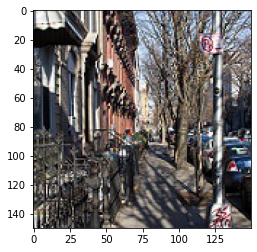

(128, 128, 3)


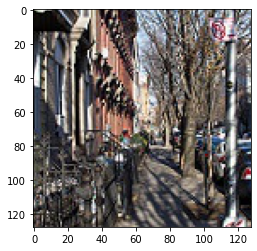

In [4]:
img_sample = Image.open("/content/dataset-naturaleza-main/seg_train/seg_train/street/999.jpg")

# show original images and its shape
plt.imshow(img_sample,cmap='gray', vmin=0, vmax=255)
print(asarray(img_sample).shape)
plt.show()

# Create a CenterCrop transform
crop = torchvision.transforms.CenterCrop(size=(128, 128))

img_sample_tensor = transforms.ToTensor()(img_sample)
# Apply the transform to the input image
cropped_img_sample = crop(img_sample_tensor)
# Convert the cropped image tensor back to a PIL.Image object
cropped_img_sample = transforms.ToPILImage()(cropped_img_sample)
# Display the cropped image and its size
print(asarray(cropped_img_sample).shape)
plt.imshow(cropped_img_sample)
plt.show()

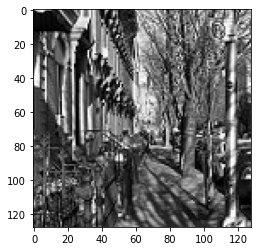

In [5]:
# generate lab, ab, and gray-scale images
img_sample = asarray(cropped_img_sample)

img_lab = rgb2lab(img_sample)
img_lab = (img_lab + 128) / 255
img_ab = img_lab[:, :, 1:3]
img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float() # shape: [2, 128, 128]

img_original = rgb2gray(img_sample)
img_original = torch.from_numpy(img_original).unsqueeze(0).float()

plt.imshow(img_original.reshape(128,128),cmap='gray')

In [6]:
def show_output(grayscale_input, ab_input):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  color_image = torch.cat((grayscale_input, ab_input), 0).detach().numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100

  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image) # .astype(np.float64)
  grayscale_input = grayscale_input.squeeze().numpy()
  return color_image

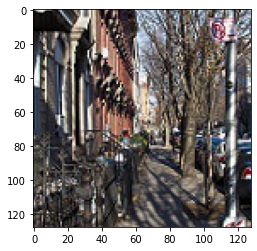

In [7]:
predicted = show_output(img_original, img_ab)
plt.imshow(predicted)

## create dataset and dataloader

### create training

In [ ]:
import os
from PIL import Image
from numpy import asarray
from skimage.color import lab2rgb, rgb2lab, rgb2gray

directory_path = '/content/dataset-naturaleza-main/seg_train/seg_train'
directory_files = os.listdir(directory_path)

images = []
grey_scale_images = []
ab_images = []
other_shape_count = 0
for classname in directory_files:
  new_directory_path = directory_path+'/'+classname
  new_directory_files = os.listdir(new_directory_path)
  for image in new_directory_files:
    img = Image.open(new_directory_path+'/'+image)
    
    # Create a CenterCrop transform
    crop = torchvision.transforms.CenterCrop(size=(128, 128))

    img_tensor = transforms.ToTensor()(img)
    # Apply the transform to the input image
    cropped_img = crop(img_tensor)
    # Convert the cropped image tensor back to a PIL.Image object
    cropped_img = transforms.ToPILImage()(cropped_img)
    images.append(asarray(cropped_img))

    # Check if the shape is in (150,150,3)
    if asarray(cropped_img).shape == (128, 128, 3):
      img = asarray(cropped_img)

      img_lab = rgb2lab(img)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float() # shape: [2, 128, 128]
      ab_images.append(img_ab)

      img_original = rgb2gray(img)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
      grey_scale_images.append(img_original)
    else:
      other_shape_count += 1
      # print(cropped_image.shape)
  #   break
  # break

In [ ]:
import random 
# View some 16 random images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow(images[random.randint(0,len(images))].reshape(128,128,3))
plt.show()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, array1, array2, array3):
        self.array1 = array1
        self.array2 = array2
        self.array3 = array3

    def __len__(self):
        return len(self.array1)

    def __getitem__(self, idx):
        return self.array1[idx], self.array2[idx], self.array3[idx]

# Create the custom dataset
dataset = CustomDataset(np.array(images), np.array(grey_scale_images), np.array(ab_images))

# Create a DataLoader from the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate over the DataLoader to check data size
for batch in dataloader:
    print(batch[0].shape)
    plt.imshow(batch[0][0].reshape(128,128,3))
    plt.show()
    print(batch[1].shape)
    plt.imshow(batch[1][0][0],cmap='gray') # , vmin=0, vmax=255
    plt.show()
    print(batch[2].shape)

    predicted = show_output(batch[1][0], batch[2][0])
    plt.imshow(predicted)
    plt.show()
    break

### create validation 

In [ ]:
import os
from PIL import Image
from numpy import asarray
from skimage.color import lab2rgb, rgb2lab, rgb2gray

directory_path = '/content/dataset-naturaleza-main/seg_test/seg_test'
directory_files = os.listdir(directory_path)

images_test = []
grey_scale_images_test = []
ab_images_test = []
other_shape_count = 0
for classname in directory_files:
  new_directory_path = directory_path+'/'+classname
  new_directory_files = os.listdir(new_directory_path)
  for image in new_directory_files:
    img = Image.open(new_directory_path+'/'+image)
    
    # Create a CenterCrop transform
    crop = torchvision.transforms.CenterCrop(size=(128, 128))

    img_tensor = transforms.ToTensor()(img)
    # Apply the transform to the input image
    cropped_img = crop(img_tensor)
    # Convert the cropped image tensor back to a PIL.Image object
    cropped_img = transforms.ToPILImage()(cropped_img)
    images_test.append(asarray(cropped_img))

    # Check if the shape is in (150,150,3)
    if asarray(cropped_img).shape == (128, 128, 3):
      img = asarray(cropped_img)

      img_lab = rgb2lab(img)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float() # shape: [2, 128, 128]
      ab_images_test.append(img_ab)


      img_original = rgb2gray(img)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
      grey_scale_images_test.append(img_original)
    else:
      other_shape_count += 1
      # print(cropped_image.shape)
  #   break
  # break

In [ ]:
# Create the custom dataset
dataset_test = CustomDataset(np.array(images_test), np.array(grey_scale_images_test), np.array(ab_images_test))

# Create a DataLoader from the dataset
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

<ipython-input-12-192095149abd>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  dataset_test = CustomDataset(np.array(images_test), np.array(grey_scale_images_test), np.array(ab_images_test))
<ipython-input-12-192095149abd>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_test = CustomDataset(np.array(images_test), np.array(grey_scale_images_test), np.array

# VAE model

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()

    MIDLEVEL_FEATURE_SIZE = 128
    resnet=models.resnet18(pretrained=True)
    resnet.conv1.weight=nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    
    self.midlevel_resnet =nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet().to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0)

In [ ]:
model.train()

train_loss_lst = []
validation_loss_lst = []

for epoch in range(20):
  # model.train()
  for i, (color_image,grey_image,ab_image) in enumerate(dataloader):
    grey_image = grey_image.to(device)
    ab_image = ab_image.to(device)

    output_ab = model(grey_image.float()) 
    loss = criterion(output_ab.float(), ab_image.float()) 
    # losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_lst.append(loss)
    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Loss {loss:.4f} \t'.format(
              epoch, i, len(dataloader), loss=loss)) 
  
  # model.eval()
  # with torch.no_grad():
  #   total_loss = 0
  #   counts = 0
  #   for i, (color_image,grey_image,ab_image) in enumerate(dataloader_test):
  #     grey_image = grey_image.to(device)
  #     ab_image = ab_image.to(device)

  #     output_ab = model(grey_image.float()) 
  #     loss = criterion(output_ab.float(), ab_image.float()) 

  #     total_loss += loss
  #     counts += 1
    
  #   validation_loss_lst.append(total_loss/counts)

In [ ]:
plt.plot(np.arange(1,len(train_loss_lst)+1), torch.tensor(train_loss_lst))
plt.title('Training loss vs weights update')
plt.xlabel('weights update')
plt.ylabel('training loss')

In [ ]:
plt.plot(np.arange(1,len(validation_loss_lst)+1), torch.tensor(validation_loss_lst))
plt.title('validation loss vs epoch')
plt.xlabel('epochs')
plt.ylabel('validation loss')

In [ ]:
torch.save(model, 'checkpoints_VAE_2.pth')

In [ ]:
import torch
model = torch.load('/content/checkpoints_VAE.pth')
# model = model.to(device)

# colorize validation dataset

In [ ]:
def show_output(grayscale_input, ab_input):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  color_image = torch.cat((grayscale_input.cpu(), ab_input.cpu()), 0).detach().numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100

  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image) # .astype(np.float64)
  grayscale_input = grayscale_input.cpu().squeeze().numpy()
  return color_image

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

fig = plt.figure(figsize=(15, 8))
for i, (orign_image,grey_image,ab_image) in enumerate(dataloader_test):
    grey_image = grey_image.to(device)
    output_ab = model(grey_image.float())
    predicted = show_output(grey_image[0], output_ab[0])

    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(grey_image[0].cpu().reshape(128,128),cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 6)
    ax.imshow(predicted)
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 11)
    ax.imshow(orign_image[0].reshape(128,128,3))
    ax.axis("off")

    if i == 4:
      break
plt.show()